# **Data Mining and Machine Learning - Team Tissot**

***Detecting the difficulty level of French texts***


In this notebook we will show the following:


1. Importing necessary packages and functions

2. Taking a look at the data

3. Logistic Regression without data cleaning

4. Knn Classifier without data cleaning

5. Decision Tree Classifier without data cleaning

6. Random Forest Classifier without data cleaning










#  1. Importing packages and functions

In [1]:
# importing packages
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
from wordcloud import WordCloud   
sns.set_style("whitegrid")

# import some additional packages for training models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

# import tqdm (progress bar)
from tqdm import tqdm

# import files to download .csv
from google.colab import files

# Importing packages for tokenization

# Install and update spaCy
!pip install -U spacy

# Download the french language model
!python -m spacy download fr_core_news_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 16.3 MB 473 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')


> Additional custom functions from our github repo



In [2]:
!pip install requests

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import requests

In [5]:
# request url
url = 'https://raw.githubusercontent.com/danieldovale/DMML2022_Tissot/main/code/custom_functions.py'
r = requests.get(url)

# write functions
with open('custom_functions.py', 'w') as f:
    f.write(r.text)

# now we can import
import custom_functions as cfun

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
from nltk.tokenize import word_tokenize, sent_tokenize 
import string
punctuations = string.punctuation

In [ ]:
import nltk
nltk.download('punkt')

---

# 2. Visualizing the data

**Loading the data and setting "id" as the index column**

In [6]:
# training data:
dfTrain = pd.read_csv("https://raw.githubusercontent.com/danieldovale/DMML2022_Tissot/main/data/training_data.csv", index_col='id')

# unlabeled test data:
dfTest = pd.read_csv("https://raw.githubusercontent.com/danieldovale/DMML2022_Tissot/main/data/unlabelled_test_data.csv", index_col='id')

**Taking a look at the data**

In [7]:
dfTrain

,sentence,difficulty
id,,
0,Les coûts kilométriques réels peuvent diverger...,C1
1,"Le bleu, c'est ma couleur préférée mais je n'a...",A1
2,Le test de niveau en français est sur le site ...,A1
3,Est-ce que ton mari est aussi de Boston?,A1
4,"Dans les écoles de commerce, dans les couloirs...",B1
...,...,...
4795,"C'est pourquoi, il décida de remplacer les hab...",B2
4796,Il avait une de ces pâleurs splendides qui don...,C1
4797,"Et le premier samedi de chaque mois, venez ren...",A2


In [8]:
dfTest

,sentence
id,
0,Nous dûmes nous excuser des propos que nous eû...
1,Vous ne pouvez pas savoir le plaisir que j'ai ...
2,"Et, paradoxalement, boire froid n'est pas la b..."
3,"Ce n'est pas étonnant, car c'est une saison my..."
4,"Le corps de Golo lui-même, d'une essence aussi..."
...,...
1195,C'est un phénomène qui trouve une accélération...
1196,Je vais parler au serveur et voir si on peut d...
1197,Il n'était pas comme tant de gens qui par pare...


**Checking for irregularity like null values or duplicate sentences in dfTrain**

In [9]:
dfTrain.isnull().sum()

sentence      0
difficulty    0
dtype: int64

In [10]:
dfTrain.duplicated(subset="sentence").value_counts()

False    4800
dtype: int64



> No null values or duplicates



**World clouds**

In [11]:
def wordcloud_function(df, title, column, fontsize = 15, 
                       figsize = (10, 10), width = 300, height = 300):
    total_text = ''.join([text for text in df[column]])
    wordcloud = WordCloud(width = width, height = height).generate(total_text)
    plt.figure(figsize = figsize)
    plt.imshow(wordcloud)
    plt.title(title, fontsize = fontsize)
    plt.show()
   

In [12]:
sns.set_style("white")

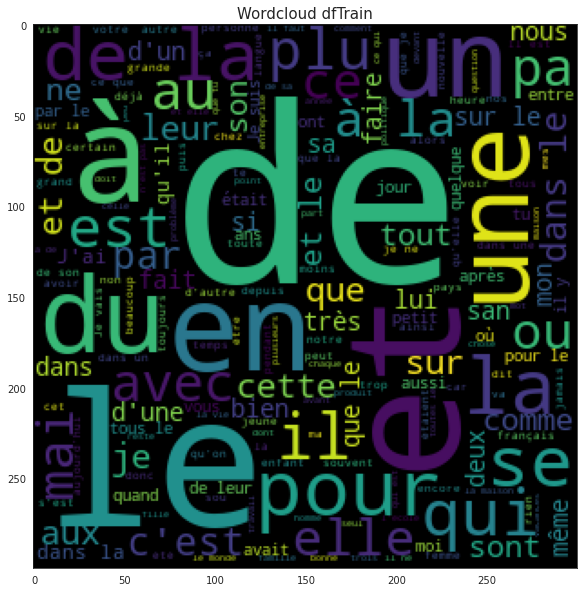

In [13]:
wordcloud_function(dfTrain, title = "Wordcloud dfTrain", column = "sentence")

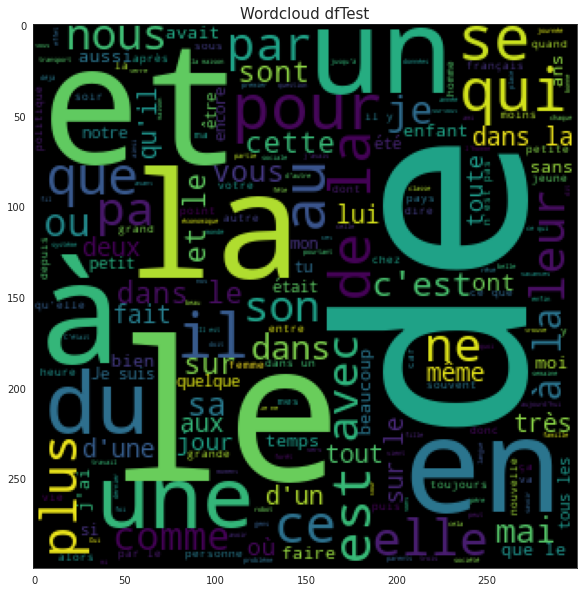

In [14]:
wordcloud_function(dfTest, title = "Wordcloud dfTest", column = "sentence")



> The two world clouds appear to have similar top words



**Distribution of difficulty**

In [15]:
sns.set_style("whitegrid")
def plot_histogram(dataframe: pd.DataFrame, column: str, x_title = None, y_title = None, edge_color = 'black', 
                   color = 'Green', total_bins = 20, font_size = 10):
    
    fig, ax = plt.subplots(figsize = (10, 5))   
    ax.hist(dataframe[column], bins = total_bins, edgecolor = edge_color, color = color)
    ax.set_title(f'Histogram Distribution of {column} values', fontsize = font_size + 5)
    ax.set_xlabel(column, fontsize = font_size)
    ax.set_ylabel("Total Number of Observations", fontsize = font_size)
    plt.show()

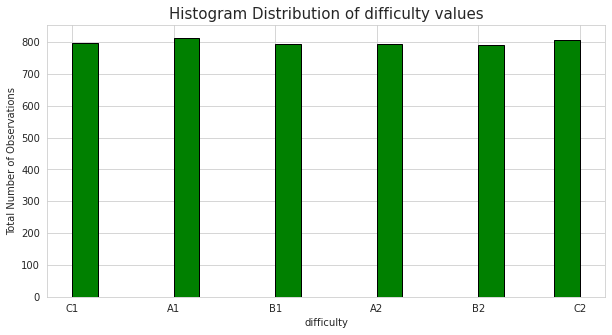

In [16]:
plot_histogram(dfTrain,column='difficulty')



> No strong imbalance in difficulty distribution



**Additional Information on dfTrain**

In [17]:
# calculating additional information using custom function
dfTrainInfo = cfun.get_info(dfTrain)

100%|██████████| 4800/4800 [00:52<00:00, 91.27it/s] 


In [18]:
# concat new info dataframe with dfTrain
dfTrainVis = (pd.concat([dfTrain,dfTrainInfo], axis = 1)).sort_values('difficulty')

In [19]:
dfTrainVis

,sentence,difficulty,text_length,number_of_sentences,number_of_words,sent_length_avg,words_length_avg,number_of_words_after_lemma_stop,longest_word_size
4582,"Je suis dans le bus, j'arrive dans 5 minutes.",A1,45,1,9,9.0,5.000000,4,8
576,C'est bientôt l'anniversaire de Julie.,A1,38,1,5,5.0,7.600000,3,14
977,Vous avez des enfants ?,A1,23,1,4,4.0,5.750000,1,7
4579,"Le temps devient de plus en plus frais, il com...",A1,85,1,19,19.0,4.473684,6,8
579,Tu parles bien anglais.,A1,23,1,4,4.0,5.750000,2,7
...,...,...,...,...,...,...,...,...,...
3993,Un enfant bilingue est éminemment favorisé par...,C2,147,1,21,21.0,7.000000,11,13
3994,"Les méthodes de la biologie synthétique, qui a...",C2,310,1,47,47.0,6.595745,25,13
3995,"À l'aise devant la vie, séduisant, nonchalant,...",C2,169,1,22,22.0,7.681818,13,13
2073,"""Comment voulez-vous demander une analyse gram...",C2,159,2,23,11.5,6.913043,12,13


**Scatter plot between number of words and difficulty**

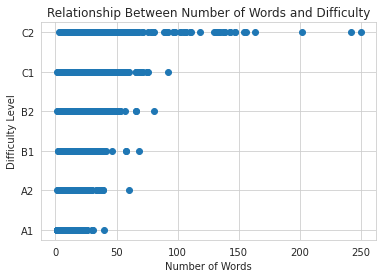

In [20]:
import matplotlib.pyplot as plt

# Extract data from dataframe
number_of_words = dfTrainVis['number_of_words'].tolist()
difficulty = dfTrainVis['difficulty'].tolist()


# # Create scatter plot
plt.scatter(number_of_words, difficulty)
plt.xlabel('Number of Words')
plt.ylabel('Difficulty Level')
plt.title('Relationship Between Number of Words and Difficulty')
plt.show()

**Baseline**

In [21]:
distribution = dfTrain['difficulty'].value_counts() 
distribution

A1    813
C2    807
C1    798
B1    795
A2    795
B2    792
Name: difficulty, dtype: int64

In [22]:
maj_bas = (distribution / len(dfTrain)).max()
print("The majority class baseline is: %s" % maj_bas)

The majority class baseline is: 0.169375


> Since our classes are almost equally balanced, a random classifier will achieve an accuracy of approximately 1/n, where n is the number of classes. 

> In our case it would be:  ~1/6 = 0.166...



---

# **First part of the project**

*Training models without data cleaning (Logistic regression, KNN, Decision Tree, Random Forests)*

Before training our models, let's split the data and define the Tfidf Vectorizer

In [23]:
# Defining X and y
X = dfTrain["sentence"]
y = dfTrain["difficulty"]

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# defining Vectorizer with default tokenizer
tfidf_vector = TfidfVectorizer(ngram_range=(1,1)) 

# 3. Logistic Regression (without data cleaning)

A simple logistic regression model using a Tfidf vectoriser. 


In [32]:
# A SUPPRIMER
#function to calculate metrics of the models
def models_metrics (true, pred):
  precision = precision_score(true, pred, average='weighted')
  recall = recall_score(true, pred, average='weighted')
  f1 = f1_score(true, pred, average='weighted')
  print(f"CONFUSION MATRIX:\n{confusion_matrix(true, pred,)}")
  print(f"ACCURACY SCORE:\n{accuracy_score(true, pred):.4f}")
  print(f"CLASSIFICATION REPORT:\n\tPrecision: {precision:.4f}\n\tRecall: {recall:.4f}\n\tF1_Score: {f1:.4f}")

In [25]:
from sklearn.linear_model import LogisticRegression

In [26]:
# Defining classifier
LR = LogisticRegression(random_state = 0)

# defining pipeline with the tfidf vectorizer 
pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', LR)])

# Fitting the model
pipe.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier', LogisticRegression(random_state=0))])

In [27]:
# predicting on the test set
y_pred_lr = pipe.predict(X_test)

,accuracy,precision,recall,f1 score
results,0.4667,0.4656,0.4667,0.464


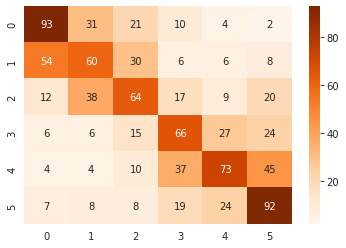

In [28]:
# calculating accuracy, precision, recall, F1 score, and showing confusion matrix using custom function
cfun.evaluate(y_test, y_pred_lr)

In [29]:
# taking a look at the accuracy by class using custom function
cfun.class_accuracy(y_test, y_pred_lr)

A1: 0.58%
A2: 0.37%
B1: 0.40%
B2: 0.46%
C1: 0.42%
C2: 0.58%


This model seems more fairly more accurate for the difficulty levels A1 and C2 (0 and 5) than for the other difficulties.

**A few examples of sentences that are not well classified**

In [40]:
# creating comparison dataframe with custom function
compare_df = cfun.pred_compare_df(X_test, y_test, y_pred_lr)
compare_df

,sentence,difficulty,predicted difficulty,correct prediction
0,"C'est en décembre 1967, après bien des invecti...",C1,C2,False
1,Giscard va pourtant réussir à transformer ce r...,C1,B2,False
2,Un choix difficile mais important : le public ...,A2,B1,False
3,Le débat porte plutôt sur l'utilité d'une tell...,B1,C1,False
4,"Et chez vous, comment va la vie ?",A1,A1,True
...,...,...,...,...
955,"Ils s'engouffraient dans les sentiers, puis se...",B2,B2,True
956,"Tous les prix sont affichés, mais si besoin, j...",A2,B2,False
957,"Très présente dans l'alimentation antillaise, ...",C1,B2,False
958,On réinvente le dimanche dans une perspective ...,C1,B1,False


In [41]:
# printing some examples using other custom function
cfun.compare(compare_df, 1)
print('-----------------')
cfun.compare(compare_df, 41)
print('-----------------')
cfun.compare(compare_df, 60)

sentence:		Giscard va pourtant réussir à transformer ce revers en tremplin
difficulty:		C1
predicted difficulty:	B2
correct prediction:	False
-----------------
sentence:		Oui c'est pour combien de personnes ?
difficulty:		A1
predicted difficulty:	A1
correct prediction:	True
-----------------
sentence:		As-tu besoin de quelque chose?
difficulty:		A1
predicted difficulty:	B1
correct prediction:	False


**First predictions on** `unlabelled_test_data.csv` **(dfTest)**

first, let's the fit on the whole data

In [36]:
pipe.fit(X, y)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier', LogisticRegression(random_state=0))])

In [37]:
# predict difficulty from dfTest
predDifficulty = pipe.predict(dfTest['sentence'])

In [39]:
# custom function to set inputted predicted difficulties in correct format for submission
# set download to True to download the .csv
cfun.prediction(predDifficulty, "LogisticRegression", download = True)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,difficulty
id,
0,C2
1,A2
2,A1
3,A1
4,C2


**Submission is a Logistic Regression without data cleaning**

**Submission score: 0.46583**



---

# 4. KNN Classifier (without data cleaning)


In [42]:
# import some additional packages
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [54]:
# Defining classifier
knn = KNeighborsClassifier()

# defining pipeline with the tfidf vectorizer
pipe = Pipeline(steps = [('vectorizer', tfidf_vector),
                 ('classifier', knn)])

# Fitting the model
pipe.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier', KNeighborsClassifier())])

In [55]:
# predicting on the test set
y_pred_knn = pipe.predict(X_test)

,accuracy,precision,recall,f1 score
results,0.3188,0.403,0.3188,0.3022


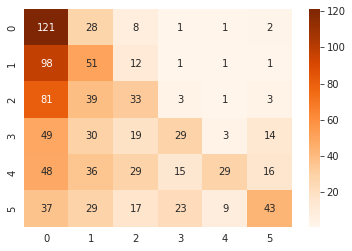

In [56]:
# calculating accuracy, precision, recall, F1 score, and showing confusion matrix using custom function
cfun.evaluate(y_test, y_pred_knn)

In [57]:
# taking a look at the accuracy by class using custom function
cfun.class_accuracy(y_test, y_pred_knn)

A1: 0.75%
A2: 0.31%
B1: 0.21%
B2: 0.20%
C1: 0.17%
C2: 0.27%


This model performed severely worse than the Logistic Regression. It seems pretty imbalaced towards the low difficulties (A1 and A2)

**KNN Hyper Parameters tuning**

In [46]:
# Import Grid Search - hyperparameter tuning
from sklearn.model_selection import GridSearchCV

Let's set and search the best parameters


In [47]:
# Defining model
knn = KNeighborsClassifier()

# Defining pipeline
pipe = Pipeline(steps = [('vectorizer', tfidf_vector),
                 ('classifier', knn)])

# Defining parameters to test
param_grid = {'classifier__n_neighbors':np.arange(1,40),
        'classifier__p':np.arange(1,3),
        'classifier__weights':['uniform','distance']
       }


search = GridSearchCV(pipe, param_grid, cv = 10)
search.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                                       ('classifier', KNeighborsClassifier())]),
             param_grid={'classifier__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39]),
                         'classifier__p': array([1, 2]),
                         'classifier__weights': ['uniform', 'distance']})

In [49]:
print("Hyperparameters:", search.best_params_)
print("Train Score:", round(search.best_score_, 4))
print("Test Score:", round(search.score(X_test, y_test), 4))

Hyperparameters: {'classifier__n_neighbors': 17, 'classifier__p': 2, 'classifier__weights': 'distance'}
Train Score: 0.3562
Test Score: 0.3594


Now let's fit our model once again using the best parameters found

In [58]:
# Define classifier
knn = KNeighborsClassifier(n_neighbors = 17, p = 2, weights = 'distance')

# Create pipeline
pipe = Pipeline([('vectorizer', tfidf_vector),
              ('classifier', knn)])

# Fit model on training set
pipe.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier',
                 KNeighborsClassifier(n_neighbors=17, weights='distance'))])

In [59]:
# predicting on the test set
y_pred_knn = pipe.predict(X_test)

,accuracy,precision,recall,f1 score
results,0.3594,0.4192,0.3594,0.3501


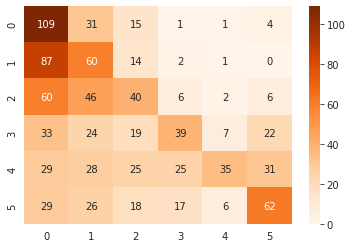

In [60]:
# calculating accuracy, precision, recall, F1 score, and showing confusion matrix using custom function
cfun.evaluate(y_test, y_pred_knn)

In [61]:
# taking a look at the accuracy by class using custom function
cfun.class_accuracy(y_test, y_pred_knn)

A1: 0.68%
A2: 0.37%
B1: 0.25%
B2: 0.27%
C1: 0.20%
C2: 0.39%


Tuning the model slightly improved the imbalace, but the model remains skewed. 

**A few examples of sentences that are not well classified**

In [62]:
# creating comparison dataframe with custom function
compare_df = cfun.pred_compare_df(X_test, y_test, y_pred_knn)
compare_df

,sentence,difficulty,predicted difficulty,correct prediction
0,"C'est en décembre 1967, après bien des invecti...",C1,B2,False
1,Giscard va pourtant réussir à transformer ce r...,C1,A1,False
2,Un choix difficile mais important : le public ...,A2,A2,True
3,Le débat porte plutôt sur l'utilité d'une tell...,B1,B2,False
4,"Et chez vous, comment va la vie ?",A1,A1,True
...,...,...,...,...
955,"Ils s'engouffraient dans les sentiers, puis se...",B2,C2,False
956,"Tous les prix sont affichés, mais si besoin, j...",A2,B1,False
957,"Très présente dans l'alimentation antillaise, ...",C1,C1,True
958,On réinvente le dimanche dans une perspective ...,C1,A1,False


In [63]:
# printing some examples using other custom function
cfun.compare(compare_df, 1)
print('-----------------')
cfun.compare(compare_df, 0)
print('-----------------')
cfun.compare(compare_df, 124)

sentence:		Giscard va pourtant réussir à transformer ce revers en tremplin
difficulty:		C1
predicted difficulty:	A1
correct prediction:	False
-----------------
sentence:		C'est en décembre 1967, après bien des invectives au Parlement, que sa loi relative à la régulation des naissances, dite loi Neuwirth est votée : elle autorise la vente exclusive des contraceptifs en pharmacie sur ordonnance médicale, avec autorisation parentale pour les mineures
difficulty:		C1
predicted difficulty:	B2
correct prediction:	False
-----------------
sentence:		Quelqu'un a essayé de brûler la maison et on ignore qui et pourquoi.
difficulty:		B1
predicted difficulty:	B1
correct prediction:	True


**Prediction on the unlabelled_test_data.csv (dfTest)**

first, let's the fit on the whole data

In [64]:
pipe.fit(X, y)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier',
                 KNeighborsClassifier(n_neighbors=17, weights='distance'))])

In [65]:
# predict difficulty from dfTest
predDifficulty = pipe.predict(dfTest['sentence'])

In [67]:
# custom function to set inputted predicted difficulties in correct format for submission
# set download to True to download the .csv
cfun.prediction(predDifficulty, "KnnTuning", False)

,difficulty
id,
0,C2
1,A2
2,A1
3,A1
4,C2


**This submission is a Hyper Paramaters tuned KNN classifier without data cleaning**

**Submission score: 0.34803**

---

# 5. Decision Tree (without data cleaning)


**Decision Tree Classification without Hyper Parameters tuning**

In [68]:
# import some additional packages 
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import cross_val_score

In [69]:
# Defining classifier
tree = DecisionTreeClassifier(random_state = 0)

# defining pipeline with the tfidf vectorizer
pipe = Pipeline(steps = [('vectorizer', tfidf_vector),
                 ('classifier', tree)])

# Fitting the model
pipe.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier', DecisionTreeClassifier(random_state=0))])

In [70]:
# predicting on the test set
y_pred_tree = pipe.predict(X_test)

,accuracy,precision,recall,f1 score
results,0.2969,0.3004,0.2969,0.2952


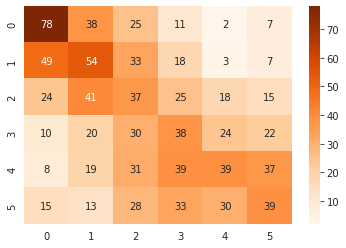

In [71]:
# calculating accuracy, precision, recall, F1 score, and showing confusion matrix using custom function
cfun.evaluate(y_test, y_pred_tree)

**Decision Tree Classifier Parameters Tuning**

In [87]:
# Defining model
tree = DecisionTreeClassifier()

# Defining pipeline
pipe = Pipeline(steps = [('vectorizer', tfidf_vector),
                 ('classifier', tree)])

# Defining parameters to test
param_grid = {'classifier__max_depth': np.arange(1,200)}


search = GridSearchCV(pipe, param_grid, cv = 5)
search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                                       ('classifier',
                                        DecisionTreeClassifier())]),
             param_grid={'classifier__max_depth': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66...
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,


In [92]:
print("Hyperparameters:", search.best_params_)
print("Train Score:", round(search.best_score_, 4))
print("Test Score:", round(search.score(X_test, y_test), 4))

Hyperparameters: {'classifier__max_depth': 16}
Train Score: 0.3174
Test Score: 0.3104


**Now let's fit our model once again using the best parameters found**

In [93]:
# Define classifier
classifier = DecisionTreeClassifier(max_depth = 16,random_state = 0)

# Create pipeline
pipe = Pipeline([('vectorizer', tfidf_vector),
              ('classifier', classifier)])

# Fit model on training set
pipe.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier',
                 DecisionTreeClassifier(max_depth=16, random_state=0))])

In [94]:
# predicting on the test set
y_pred_tree = pipe.predict(X_test)

,accuracy,precision,recall,f1 score
results,0.3156,0.3158,0.3156,0.3008


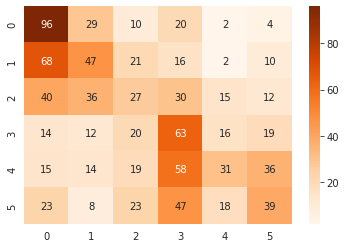

In [95]:
# calculating accuracy, precision, recall, F1 score, and showing confusion matrix using custom function
cfun.evaluate(y_test, y_pred_tree)

comments todo

**A few examples of sentences that are not well classified**

In [96]:
# creating comparison dataframe with custom function
compare_df = cfun.pred_compare_df(X_test, y_test, y_pred_tree)
compare_df

,sentence,difficulty,predicted difficulty,correct prediction
0,"C'est en décembre 1967, après bien des invecti...",C1,A2,False
1,Giscard va pourtant réussir à transformer ce r...,C1,A1,False
2,Un choix difficile mais important : le public ...,A2,C2,False
3,Le débat porte plutôt sur l'utilité d'une tell...,B1,C1,False
4,"Et chez vous, comment va la vie ?",A1,A1,True
...,...,...,...,...
955,"Ils s'engouffraient dans les sentiers, puis se...",B2,A2,False
956,"Tous les prix sont affichés, mais si besoin, j...",A2,C1,False
957,"Très présente dans l'alimentation antillaise, ...",C1,B2,False
958,On réinvente le dimanche dans une perspective ...,C1,A1,False


In [97]:
# printing some examples using other custom function
cfun.compare(compare_df, 1)
print('-----------------')
cfun.compare(compare_df, 41)
print('-----------------')
cfun.compare(compare_df, 60)

sentence:		Giscard va pourtant réussir à transformer ce revers en tremplin
difficulty:		C1
predicted difficulty:	A1
correct prediction:	False
-----------------
sentence:		Oui c'est pour combien de personnes ?
difficulty:		A1
predicted difficulty:	A2
correct prediction:	False
-----------------
sentence:		As-tu besoin de quelque chose?
difficulty:		A1
predicted difficulty:	B1
correct prediction:	False


**Predictions on the `unlabelled_test_data.csv` (dfTest)**

first, let's the fit on the whole data

In [98]:
pipe.fit(X, y)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier',
                 DecisionTreeClassifier(max_depth=16, random_state=0))])

In [99]:
# predict difficulty from dfTest
predDifficulty = pipe.predict(dfTest['sentence'])

In [100]:
# custom function to set inputted predicted difficulties in correct format for submission
# set download to True to download the .csv
cfun.prediction(predDifficulty, "DecisionTreeTuning", False)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,difficulty
id,
0,B2
1,B1
2,A1
3,A1
4,C2


**Submission is a Hyper Parameters tuned Decision Tree classifier without data cleaning**

**score: 0.31833**

---

# 6. Random Forests (without data cleaning)


In [101]:
# import some additional packages
from sklearn.ensemble import RandomForestClassifier

In [102]:
# Define classifier
forest = RandomForestClassifier(random_state = 0)

# Create pipeline
pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', forest)])

# Fit model on training set
pipe.fit(X_train, y_train)

# Predictions
y_pred_forest = pipe.predict(X_test)

,accuracy,precision,recall,f1 score
results,0.4135,0.4228,0.4135,0.4


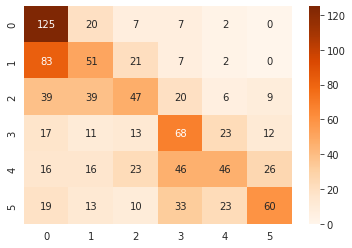

In [103]:
# calculating accuracy, precision, recall, F1 score, and showing confusion matrix using custom function
cfun.evaluate(y_test, y_pred_forest)

**A few examples of sentences that are not well classified**

In [104]:
# creating comparison dataframe with custom function
compare_df = cfun.pred_compare_df(X_test, y_test, y_pred_forest)
compare_df

,sentence,difficulty,predicted difficulty,correct prediction
0,"C'est en décembre 1967, après bien des invecti...",C1,B2,False
1,Giscard va pourtant réussir à transformer ce r...,C1,A1,False
2,Un choix difficile mais important : le public ...,A2,B2,False
3,Le débat porte plutôt sur l'utilité d'une tell...,B1,C1,False
4,"Et chez vous, comment va la vie ?",A1,A1,True
...,...,...,...,...
955,"Ils s'engouffraient dans les sentiers, puis se...",B2,B2,True
956,"Tous les prix sont affichés, mais si besoin, j...",A2,B2,False
957,"Très présente dans l'alimentation antillaise, ...",C1,B2,False
958,On réinvente le dimanche dans une perspective ...,C1,B1,False


In [114]:
# printing some examples using other custom function
cfun.compare(compare_df, 1)
print('-----------------')
cfun.compare(compare_df, 104)
print('-----------------')
cfun.compare(compare_df, 100)

sentence:		Giscard va pourtant réussir à transformer ce revers en tremplin
difficulty:		C1
predicted difficulty:	A1
correct prediction:	False
-----------------
sentence:		J'ai réservé pour deux nuits.
difficulty:		A1
predicted difficulty:	A1
correct prediction:	True
-----------------
sentence:		C'est une bonne nouvelle, mais comment je vais faire dans une si grande ville alors que j'adore la nature?
difficulty:		A2
predicted difficulty:	B1
correct prediction:	False


**Predictions on** `unlabelled_test_data.csv` **(dfTest)**

first, let's the fit on the whole data

In [115]:
pipe.fit(X, y)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier', RandomForestClassifier(random_state=0))])

In [116]:
# predict difficulty from dfTest
predDifficulty = pipe.predict(dfTest['sentence'])

In [117]:
# custom function to set inputted predicted difficulties in correct format for submission
# set download to True to download the .csv
cfun.prediction(predDifficulty, "RandomForestClassifier", download = False)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,difficulty
id,
0,B2
1,B1
2,A2
3,A1
4,C2


**This Submission is a Random Forest Classification without data cleaning**

**Submission score: 0.395**



---




# 7. Results Summary

|       | Logistic Regression | KNeighbors Classifier |  Decision Tree | Random Forests 
| :---       |   :----:   |  :----: |  :----:   |  :----: |
| **Precision**| 0.4556 | 0.4192 | 0.3158 | 0.4228 |
| **Recall**   | 0.4667 | 0.3594 | 0.3156 | 0.4135 |
| **F1-score** | 0.4640 | 0.3501 | 0.3008 | 0.4000 |
| **Accuracy** | 0.4667 | 0.3594 | 0.3156 | 0.4135 |
| **Submission Score**| **0.46583** | **0.34083** | **0.31833** | **0.39500**|

Confusion Matrices 


          Logistic Regression                 KNeighbors Classifier                   Decision Tree                        Random Forests   
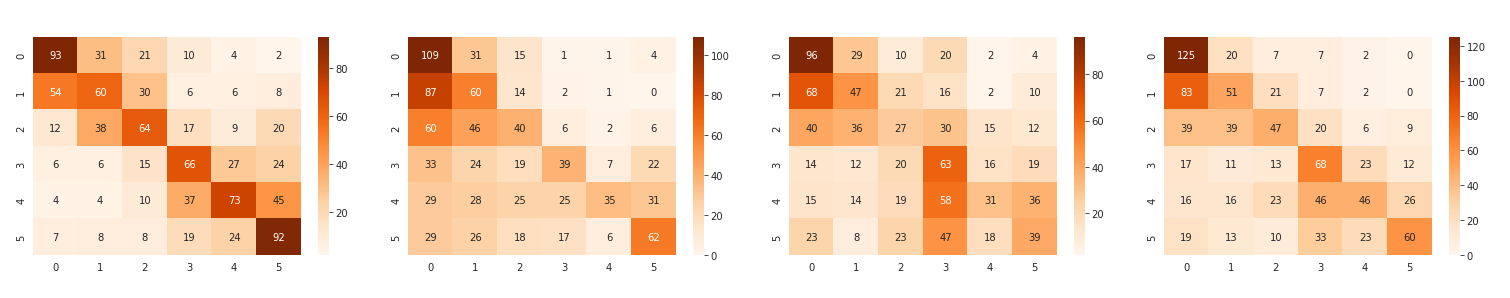